In [62]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from sklearn.datasets import load_iris, load_boston
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [63]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

# Загрузка набора данных
Для лабораторной работы будем использовать набор данных со [спам-сообщениями](https://www.kaggle.com/team-ai/spam-text-message-classification).
<a id='data_desc'></a> 

<b>Задача </b> состоит в предсказании, является ли это сообщение спамом.

Колонки:

1. `Category` - спам/не-спам
2. `Message` -  сообщение

In [64]:
data = pd.read_csv('../data/spam.csv', sep = ',')
data

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [65]:
# Типы данных в колонках
data.dtypes

Category    object
Message     object
dtype: object

### Проверка на наличие пропущенных значений

In [66]:
data.isnull().sum()

Category    0
Message     0
dtype: int64

Пропущенные значения не найдены.

Преобразуем категориальный признак в числовой:

In [67]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#пол
le.fit(data.Category.drop_duplicates()) 
data.Category = le.transform(data.Category)

спам = 1

не-спам = 0

In [68]:
data.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Векторизация

Сформируем общий словарь для обучения моделей из обучающей и тестовой выборки

In [69]:
vocab_list = data['Message'].tolist()
vocab_list[1:10]

['Ok lar... Joking wif u oni...',
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'U dun say so early hor... U c already then say...',
 "Nah I don't think he goes to usf, he lives around here though",
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",
 'Even my brother is not like to speak with me. They treat me like aids patent.',
 "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',
 'Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobil

Создание векторизатора:

In [70]:
vocabVect = CountVectorizer()
vocabVect.fit(vocab_list)
corpusVocab = vocabVect.vocabulary_
print('Количество сформированных признаков - {}'.format(len(corpusVocab)))

Количество сформированных признаков - 8709


In [71]:
for i in list(corpusVocab)[1:10]:
    print('{}={}'.format(i, corpusVocab[i]))

until=8080
jurong=4370
point=5954
crazy=2334
available=1313
only=5567
in=4110
bugis=1763
great=3651


Сначала в словаре идут все номера, которые попадались в спам-сообщениях:

In [72]:
vocabVect.get_feature_names()[10:20]

['0207',
 '02072069400',
 '02073162414',
 '02085076972',
 '021',
 '03',
 '04',
 '0430',
 '05',
 '050703']

После них уже идут все обнаруженные слова:

In [73]:
vocabVect.get_feature_names()[3000:3010]

['euro',
 'euro2004',
 'eurodisinc',
 'europe',
 'evaluation',
 'evaporated',
 'eve',
 'eveb',
 'even',
 'evening']

### Использование N-грам

Создадим словарь, содержащий словосочетания, состоящие из 1, 2, 3 слов

In [74]:
ncv = CountVectorizer(ngram_range=(1,3))
ngram_features = ncv.fit_transform(vocab_list)
print('Обнаружено словосочетаний:',len(ncv.get_feature_names()))

Обнаружено словосочетаний: 104934


Примеры словосочетаний:

In [75]:
print(ncv.get_feature_names()[1000:1010],'\n')
print(ncv.get_feature_names()[7000:7010])

['10k cash', '10k cash or', '10p', '10p min', '10p min mob', '10p min only', '10p min stop', '10p min to', '10p per', '10p per min'] 

['and more when', 'and must', 'and must say', 'and my', 'and my amigos', 'and my constant', 'and my diet', 'and my man', 'and my mumhas', 'and my sister']


# Решение задачи классификации

In [76]:
def VectorizeAndClassify(vectorizers_list, classifiers_list):
    for v in vectorizers_list:
        for c in classifiers_list:
            pipeline1 = Pipeline([("vectorizer", v), ("classifier", c)])
            score = cross_val_score(pipeline1, data['Message'], data['Category'], scoring='accuracy', cv=3).mean()
            print('Векторизация - {}'.format(v))
            print('Модель для классификации - {}'.format(c))
            print('Accuracy = {}'.format(score))
            print('===========================')

In [77]:
vectorizers_list = [CountVectorizer(vocabulary = corpusVocab), TfidfVectorizer(vocabulary = corpusVocab)]
classifiers_list = [LogisticRegression(C=3.0), LinearSVC(), KNeighborsClassifier()]
VectorizeAndClassify(vectorizers_list, classifiers_list)

C:\Users\volko\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Векторизация - CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None,
                vocabulary={'00': 0, '000': 1, '000pes': 2, '008704050406': 3,
                            '0089': 4, '0121': 5, '01223585236': 6,
                            '01223585334': 7, '0125698789': 8, '02': 9,
                            '0207': 10, '02072069400': 11, '02073162414': 12,
                            '02085076972': 13, '021': 14, '03': 15, '04': 16,
                            '0430': 17, '05': 18, '050703': 19, '0578': 20,
                            '06': 21, '07': 22, '07008009200': 23,
                            '07046744435': 24, '07090201529': 25,
   

C:\Users\volko\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Векторизация - TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use...
                vocabulary={'00': 0, '000': 1, '000pes': 2, '008704050406': 3,
                            '0089': 4, '0121': 5, '01223585236': 6,
                            '01223585334': 7, '0125698789': 8, '02': 9,
                            '0207': 10, '02072069400': 11, '02073162414': 12,
                            '02085076972': 13, '021': 14, '03': 15, '04': 16,
                            '0430': 17, '05': 18, '050703': 19, '0578': 20,
                            '06': 21, '07': 22, '07008009200': 

Все модели имеют высокие показатели качества, даже метод ближайших соседей в CountVectorizer имеет точность 0.91.

Лучшая точно была получения при использовании CountVectorizer с методом опорных векторов. Точность: 0.983.

Интересно, что с логистической регрессией и методом опорных веткоров хуже себя показал TfidfVectorizer, хотя ожидалось обратное.

# Разделим выборку на обучающую и тестовую и проверим решение для лучшей модели

In [78]:
def sentiment(v, c):
    model = Pipeline(
        [("vectorizer", v), 
         ("classifier", c)])
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    print_accuracy_score_for_classes(Y_test, Y_pred)

In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(data['Message'],
                                                    data['Category'],
                                                    test_size=0.05,
                                                    random_state=1)

In [80]:
sentiment(CountVectorizer(), LinearSVC())

Метка 	 Accuracy
0 	 1.0
1 	 0.9166666666666666


In [81]:
sentiment(CountVectorizer(ngram_range=(1,3)), LinearSVC())

Метка 	 Accuracy
0 	 1.0
1 	 0.8888888888888888


In [82]:
sentiment(CountVectorizer(ngram_range=(2,3)), LinearSVC())

Метка 	 Accuracy
0 	 1.0
1 	 0.75


In [83]:
sentiment(CountVectorizer(ngram_range=(1,4)), LinearSVC())

Метка 	 Accuracy
0 	 1.0
1 	 0.8611111111111112


C:\Users\volko\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [84]:
sentiment(CountVectorizer(ngram_range=(2,4)), LinearSVC())

Метка 	 Accuracy
0 	 1.0
1 	 0.7222222222222222


Лучше всего себя показала комбинация просто векторизатора без словосочетаний. Также видно, что при удалении из N-грам словосочетаний длиной 1 точность падает.

Скорее всего дело в том, что спам-сообщения легко определить по ключевым словам, таким как 'free', 'coupon' и т.д., а также по странным комбинациям цифр, представляющим собой какой-то промо-код или номер телефона.

Словосочетания уже роли особой не играют.

# Решение задачи классификации текстов с использованием Байесовских методов

Оценим распределение целевого признака

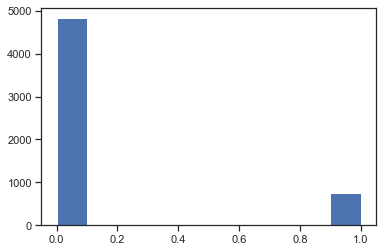

In [85]:
plt.hist(data['Category'])
plt.show()

Спама намного меньше.

Для выборок с сильным дисбалансом классов принято применять <b>Complement Naive Bayes

In [86]:
sentiment(CountVectorizer(), ComplementNB())

Метка 	 Accuracy
0 	 0.9917695473251029
1 	 0.9722222222222222


In [87]:
sentiment(TfidfVectorizer(), ComplementNB())

Метка 	 Accuracy
0 	 0.9958847736625515
1 	 0.9444444444444444


Точность для метки 0 упала совсем незначительно по сравнению с CountVectorizer с методом опорных векторов, зато сильно выросла точность для метки 1.

Задачей для данного набора данных является точное определение спам-сообщений, поэтому точность определения метки 1 намного важнее.

Наивный Байесовский метод показал себя лучше.

Попробуем другие методы:

In [88]:
sentiment(CountVectorizer(), MultinomialNB())

Метка 	 Accuracy
0 	 0.9958847736625515
1 	 0.9722222222222222


In [89]:
sentiment(TfidfVectorizer(), MultinomialNB())

Метка 	 Accuracy
0 	 1.0
1 	 0.7222222222222222


In [90]:
sentiment(CountVectorizer(binary=True), BernoulliNB())

Метка 	 Accuracy
0 	 0.9958847736625515
1 	 0.8611111111111112


Лучшим можно считать pipeline из CountVectorizer и  Complement Naive Bayes.